# Übung: Alarmmanagement – Datenanalyse und Alarmflutklassifikation

In dieser Übung durchlaufen Sie eine vollständige Pipeline des industriellen Alarmmanagements. Ziel ist es, die grundlegenden Konzepte praktisch umzusetzen, von der Verarbeitung realer Prozessdaten über die Berechnung von Alarmmetriken bis hin zur Implementierung und Auswertung von Methoden zur Klassifikation von Alarmfluten.

**Lernziele:**
- Umgang mit industriellen Alarmdaten
- Berechnung relevanter Alarmmetriken
- Implementierung einfacher Techniken (z.B. Alarm-Totbänder)
- Extraktion von Merkmalen zur Klassifikation von Alarmfluten (WDI-1NN & ACM-SVM)
- Evaluation der Klassifikationsergebnisse (Confusion Matrix, Genauigkeit)

Die jeweiligen Stellen zur eigenständigen Implementierung sind im Notebook mit **"TODO"** klar gekennzeichnet.

In [1]:
import numpy as np
import pandas as pd

## 1. Datensatz laden und erkunden

Laden Sie den bereitgestellten Datensatz mit vorannotierten Alarmfluten. Erkunden Sie anschließend die Struktur der Daten.

- Prozessvariablen und Alarmfluten sind bereits enthalten.
- Gelabelte Klassen (Klassen 0 bis 4) liegen ebenfalls vor (z.B. Ursachen für Alarmfluten).

In [2]:
# Leere Listen für Daten und Labels initialisieren
data = []
labels = []

for j in range(1, 1001):
    # Pfad zur CSV-Datei
    csv_file_path = 'process_data/sample_{}.csv'.format(j)
    # Lese die Daten aus der CSV-Datei
    df = pd.read_csv(csv_file_path, index_col=None)
    df = df.drop(df.columns[0], axis=1)
    if j in range(1, 201):
        l = 0
    elif j in range(201, 401):
        l = 1
    elif j in range(401, 601):
        l = 2
    elif j in range(601, 801):
        l = 3
    elif j in range(801, 1001):
        l = 4
        # continue
    labels.append(l)
    data.append(df.values.transpose())

# Speichere die Prozessvariablennamen in einer Liste
process_variables = df.columns.tolist()

# Konvertiere Daten und Labels in numpy-Arrays
X = np.array(data)
y = np.array(labels)

# Gib die Form der Daten und Labels aus
print("Datenform: {}".format(X.shape))
print("Labels-Form: {}".format(y.shape))
unique, counts = np.unique(y, return_counts=True)
print("Klassenverteilung:")
for cls, cnt in zip(unique, counts):
    print(f"Klasse {cls}: {cnt}")

Datenform: (1000, 73, 300)
Labels-Form: (1000,)
Klassenverteilung:
Klasse 0: 200
Klasse 1: 200
Klasse 2: 200
Klasse 3: 200
Klasse 4: 200


## 2. Alarmdaten aus Prozessdaten generieren

### 2.1 Binäre Alarmdaten generieren

In diesem Schritt generieren Sie binäre Alarmdaten aus den Prozessdaten (`X`). Die Alarmgrenzwerte sind vorgegeben. Jede Prozessvariable besitzt zwei Alarmgrenzwerte:

- **HI-Alarm**: Aktiviert, wenn der Wert einer Prozessvariablen über den oberen Grenzwert (`alarm_limits_hi`) steigt.
- **LO-Alarm**: Aktiviert, wenn der Wert einer Prozessvariablen unter den unteren Grenzwert (`alarm_limits_lo`) fällt.

**Gehen Sie wie folgt vor:**

1. Initialisieren Sie ein Array zur Speicherung der binären Alarmdaten (`X_alarms`).
2. Berechnen Sie für jede Prozessvariable und jeden Zeitschritt jedes Samples, ob der HI- oder LO-Grenzwert verletzt wird.
3. Speichern Sie die Ergebnisse in binärer Form (1 = Alarm aktiv, 0 = Alarm inaktiv).

**Hilfreiche Hinweise:**

- Das resultierende Array `X_alarms` hat doppelt so viele Variablen wie das ursprüngliche Prozessdatenarray `X` (jeweils HI- und LO-Alarme für jede Prozessvariable).
- Prüfen Sie abschließend, ob die Dimensionen der generierten Alarmdaten korrekt sind.


- Ein Alarm wird aktiv, wenn der Grenzwert überschritten wird (HI-Alarm) oder unterschritten wird (LO-Alarm).

In [3]:
# Alarmgrenzwerte automatisch aus Mittelwert und Standardabweichung berechnen

# X hat die Form (num_samples, num_variables, num_timesteps)
# Wir berechnen für jede Prozessvariable (über alle Samples und Timesteps) den Mittelwert und die Standardabweichung

# Mittelwerte und Standardabweichungen pro Variable berechnen, über Samples und Zeitschritte
# Ergibt shape: (num_variables,)
means = X.mean(axis=(0, 2))
stds = X.std(axis=(0, 2))

# Berechnung der HI- und LO-Grenzwerte pro Variable (shape: num_variables)
alarm_limits_hi = means + stds
alarm_limits_lo = means - stds

# Ausgabe der berechneten Grenzwerte für jede Prozessvariable
print("Berechnete Alarmgrenzwerte (HI/LO) pro Prozessvariable:")
for i, name in enumerate(process_variables):
    hi_limit = alarm_limits_hi[i]
    lo_limit = alarm_limits_lo[i]
    print(f"{name}: HI-Grenzwert = {hi_limit:.2f}, LO-Grenzwert = {lo_limit:.2f}")

Berechnete Alarmgrenzwerte (HI/LO) pro Prozessvariable:
XMEAS1: HI-Grenzwert = 0.67, LO-Grenzwert = 0.13
XMEAS2: HI-Grenzwert = 3677.32, LO-Grenzwert = 3637.12
XMEAS3: HI-Grenzwert = 4497.32, LO-Grenzwert = 4429.23
XMEAS4: HI-Grenzwert = 9.32, LO-Grenzwert = 8.82
XMEAS5: HI-Grenzwert = 32.50, LO-Grenzwert = 30.57
XMEAS6: HI-Grenzwert = 47.70, LO-Grenzwert = 45.73
XMEAS7: HI-Grenzwert = 2804.75, LO-Grenzwert = 2792.61
XMEAS8: HI-Grenzwert = 65.99, LO-Grenzwert = 64.68
XMEAS9: HI-Grenzwert = 122.96, LO-Grenzwert = 122.84
XMEAS10: HI-Grenzwert = 0.37, LO-Grenzwert = 0.11
XMEAS11: HI-Grenzwert = 92.26, LO-Grenzwert = 90.04
XMEAS12: HI-Grenzwert = 52.51, LO-Grenzwert = 47.50
XMEAS13: HI-Grenzwert = 2709.17, LO-Grenzwert = 2697.21
XMEAS14: HI-Grenzwert = 25.64, LO-Grenzwert = 24.95
XMEAS15: HI-Grenzwert = 50.93, LO-Grenzwert = 41.06
XMEAS16: HI-Grenzwert = 3337.77, LO-Grenzwert = 3323.67
XMEAS17: HI-Grenzwert = 22.97, LO-Grenzwert = 22.71
XMEAS18: HI-Grenzwert = 66.97, LO-Grenzwert = 64.77
X

In [4]:
# Binäre Alarmdaten initialisieren
num_samples, num_variables, num_timesteps = X.shape
X_alarms = np.zeros((num_samples, num_variables * 2, num_timesteps))

# Alarme generieren
for sample_idx in range(num_samples):
    for var_idx in range(num_variables):
        hi_limit = alarm_limits_hi[var_idx]
        lo_limit = alarm_limits_lo[var_idx]

        # High-Alarm aktiv, wenn Wert > HI-Limit
        X_alarms[sample_idx, var_idx, :] = (X[sample_idx, var_idx, :] > hi_limit).astype(int)

        # Low-Alarm aktiv, wenn Wert < LO-Limit
        X_alarms[sample_idx, var_idx + num_variables, :] = (X[sample_idx, var_idx, :] < lo_limit).astype(int)

# Ausgabe zur Kontrolle
print("Shape der generierten Alarmdaten:", X_alarms.shape)

Shape der generierten Alarmdaten: (1000, 146, 300)


### 2.2 Alarmdaten visualisieren

Visualisieren Sie anschließend für jede Alarmklasse die mittlere Alarmaktivität als Heatmap.

Gehen Sie dabei wie folgt vor:

1. Gruppieren Sie die Alarmdaten nach den vorgegebenen Klassen.
2. Berechnen Sie den Durchschnitt der Alarmaktivität pro Klasse (über alle Samples).
3. Stellen Sie die Ergebnisse für jede Klasse übersichtlich als Heatmap dar:
   - **X-Achse**: Zeitverlauf
   - **Y-Achse**: Index der Alarmvariablen
   - **Farbe**: mittlere Alarmaktivität (zwischen 0 = nie aktiv und 1 = dauerhaft aktiv)

**Hilfreiche Funktionen:**

- Nutzen Sie `np.unique` zur Identifikation der Klassen und `np.where` zur Auswahl der zugehörigen Samples.
- Verwenden Sie die `imshow`-Funktion von `matplotlib`, um die Heatmap zu erzeugen.


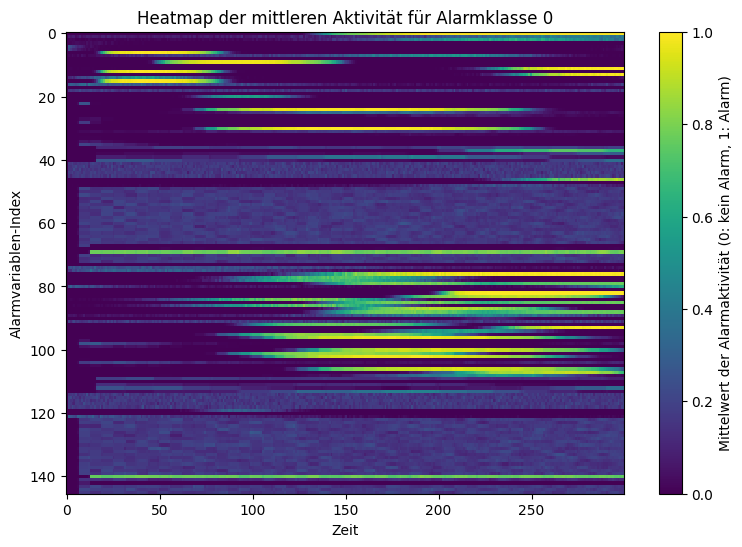

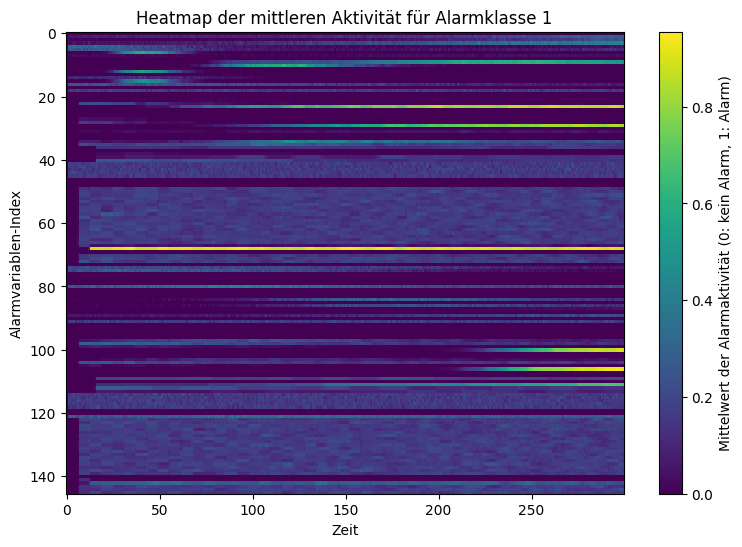

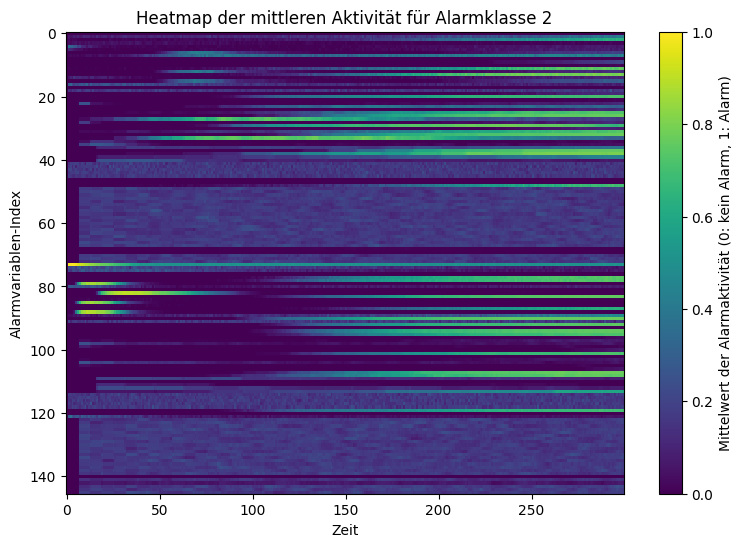

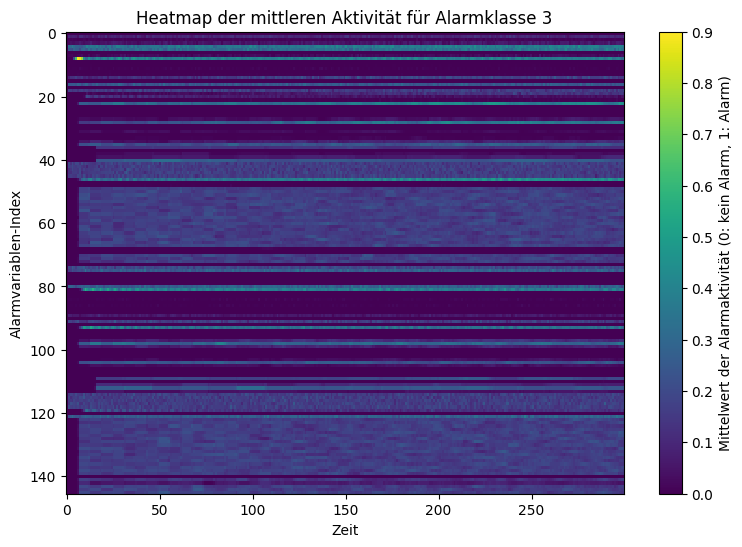

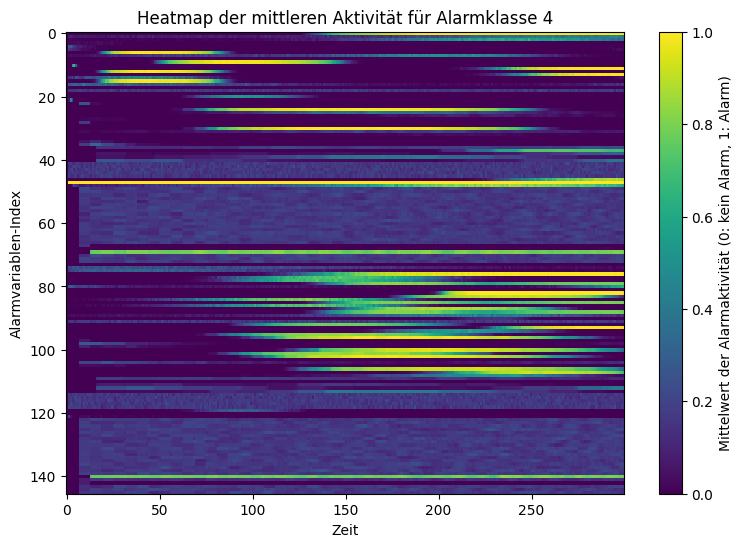

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Für jede Klasse in y
for alarm_class in np.unique(y):
    # Indizes der Samples dieser Klasse
    idx = np.where(y == alarm_class)[0]
    # Mittelwert über alle Samples dieser Klasse (über axis=0)
    mean_activity = X_alarms[idx].mean(axis=0)  # shape: (num_variables, num_timesteps)
    
    # Heatmap plotten
    plt.figure(figsize=(9, 6))
    plt.imshow(mean_activity, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.xlabel('Zeit')
    plt.ylabel('Alarmvariablen-Index')
    plt.title(f'Heatmap der mittleren Aktivität für Alarmklasse {alarm_class}')
    plt.colorbar(label='Mittelwert der Alarmaktivität (0: kein Alarm, 1: Alarm)')
    plt.show()

### 2.3 Charakteristische Alarmvariablen identifizieren und visualisieren

In dieser Aufgabe analysieren Sie, welche Alarmvariablen **besonders charakteristisch für jede Alarmklasse** sind. Dafür bauen Sie auf Aufgabe 2.2 auf.

Gehen Sie wie folgt vor:

1. Legen Sie eine Schwelle (z.B. `threshold = 0.3`) für die mittlere Alarmaktivität fest.
2. Berechnen Sie für jede Alarmvariable die mittlere Aktivität über alle Zeitschritte und alle Samples der jeweiligen Klasse.
3. Wählen Sie nur die Alarmvariablen aus, deren mittlere Aktivität mindestens so groß wie der gewählte Grenzwert ist.
4. Visualisieren Sie anschließend für jede Alarmklasse nur diese charakteristischen Alarmvariablen als Heatmap:
   - **X-Achse:** Zeitverlauf
   - **Y-Achse:** Index der charakteristischen Alarmvariablen
   - **Farbe:** mittlere Alarmaktivität der Variablen (zwischen 0 und 1)

**Hilfreiche Hinweise:**

- Verwenden Sie erneut `np.unique`, `np.where` und die Visualisierung mit `imshow`.
- Achten Sie darauf, in der Heatmap die Originalindizes der ausgewählten Alarmvariablen deutlich sichtbar darzustellen.
- Wenn für eine Klasse keine Alarmvariablen die Schwelle überschreiten, geben Sie einen entsprechenden Hinweis aus.

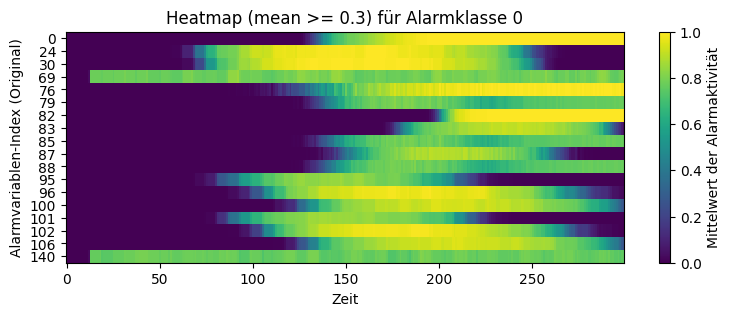

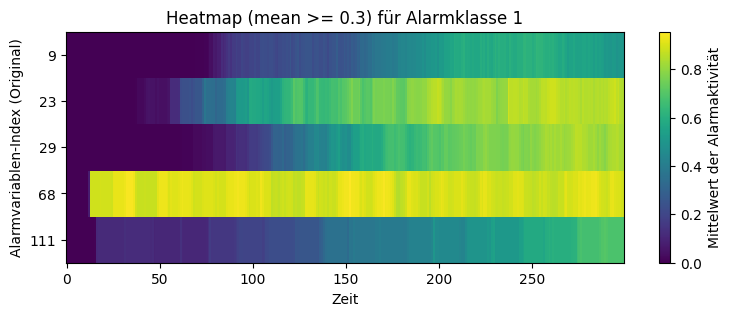

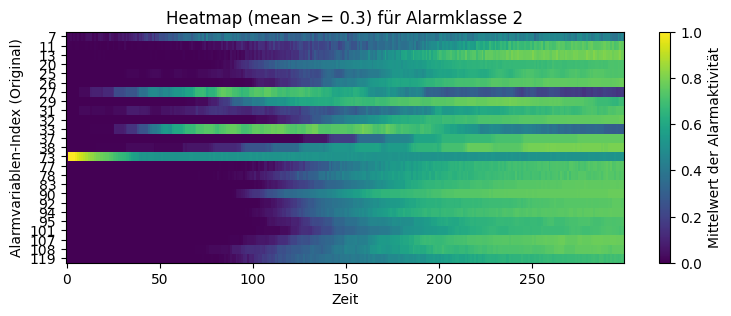

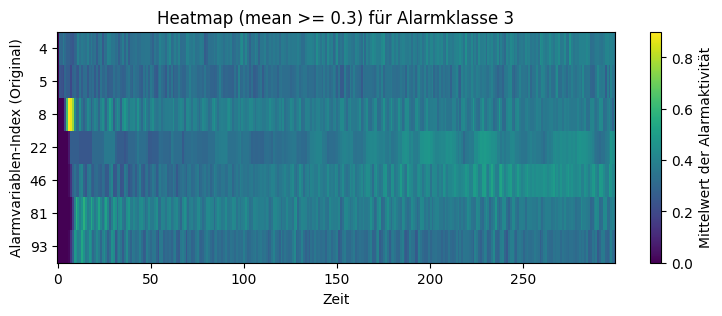

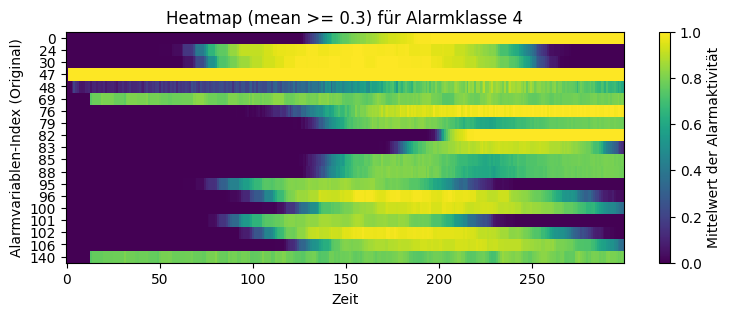

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Setzen der Schwelle für Alarmvariablen
threshold = 0.3

# Für jede Klasse in y
for alarm_class in np.unique(y):
    # Indizes der Samples dieser Klasse
    idx = np.where(y == alarm_class)[0]
    # Mittelwert über alle Samples dieser Klasse (über axis=0)
    mean_activity = X_alarms[idx].mean(axis=0)  # shape: (num_variables, num_timesteps)
    # Mittelwert über die Zeit für jede Alarmvariable
    mean_over_time = mean_activity.mean(axis=1)
    # Indizes der Alarmvariablen mit mean >= threshold (Originalindizes merken)
    selected_vars = np.where(mean_over_time >= threshold)[0]
    original_indices = selected_vars  # Originalindizes speichern
    if len(selected_vars) == 0:
        print(f"Klasse {alarm_class}: Keine Alarmvariablen mit mean>={threshold} gefunden.")
        continue
    # Nur die ausgewählten Variablen plotten, y-Achse mit Originalindizes beschriften
    plt.figure(figsize=(9, 3))
    plt.imshow(mean_activity[selected_vars, :], aspect='auto', cmap='viridis', interpolation='nearest')
    plt.xlabel('Zeit')
    plt.ylabel('Alarmvariablen-Index (Original)')
    plt.yticks(ticks=np.arange(len(original_indices)), labels=original_indices)
    plt.title(f'Heatmap (mean >= {threshold}) für Alarmklasse {alarm_class}')
    plt.colorbar(label='Mittelwert der Alarmaktivität')
    plt.show()

## 3. Berechnung relevanter Alarmmetriken und Visualisierung

In diesem Schritt berechnen und visualisieren Sie relevante Metriken, um das Verhalten der Alarmdaten über die Zeit besser zu verstehen. Hierfür teilen Sie die Zeitreihe in Intervalle von jeweils 10 Zeitschritten ein und analysieren folgende Metriken für alle Alarmfluten:

- **Aktive Alarme pro Intervall**:
  - Durchschnittliche Anzahl der Alarmvariablen, die innerhalb eines 10-Zeitschritte-Intervalls mindestens einmal aktiv sind.
  - Maximale Anzahl der gleichzeitig aktiven Alarmvariablen in einem Intervall (über alle Samples).

- **Neu aktivierte Alarme pro Intervall**:
  - Durchschnittliche Anzahl der Alarmvariablen, die innerhalb eines Intervalls neu aktiviert wurden (Übergang von inaktiv zu aktiv).
  - Maximale Anzahl der neu aktivierten Alarmvariablen in einem Intervall (über alle Samples).

**Visualisierung der Ergebnisse:**

Erstellen Sie jeweils für die aktiven und neu aktivierten Alarmvariablen geeignete Diagramme, um die durchschnittlichen und maximalen Werte übersichtlich darzustellen.

**Interpretation:**

- Welche Aussagen können Sie anhand der Diagramme treffen?
- Wie unterscheiden sich durchschnittliche und maximale Werte?
- Was sagt die mittlere Anzahl neu aktivierter Alarme über das Auftreten von Alarmfluten aus?

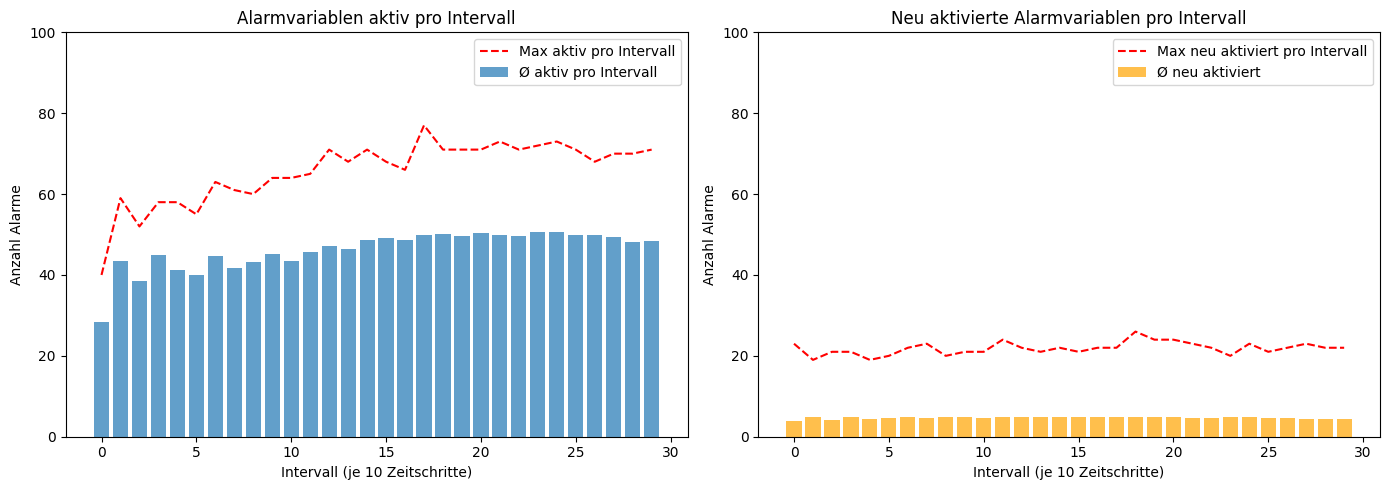

Mittelwert der durchschnittlichen neu aktivierten Alarme pro Intervall: 4.6912666666666665


In [7]:
import matplotlib.pyplot as plt
import numpy as np

interval = 10
num_intervals = num_timesteps // interval

# Listen zur Speicherung der Ergebnisse
avg_active_per_interval = []
max_active_per_interval = []

avg_new_active_per_interval = []
max_new_active_per_interval = []

for i in range(num_intervals):
    start = i * interval
    end = (i + 1) * interval
    
    # Ausschnitt der Alarme für aktuelles Intervall
    interval_alarms = X_alarms[:, :, start:end]
    
    # Überprüfung: war Alarmvariable mindestens einmal im Intervall aktiv? (1 oder 0 pro Variable und Sample)
    active_once = (interval_alarms.sum(axis=2) > 0).astype(int)
    avg_active = active_once.sum(axis=1).mean()          # Mittelwert über alle Samples
    max_active = active_once.sum(axis=1).max()           # Maximum über alle Samples
    
    avg_active_per_interval.append(avg_active)
    max_active_per_interval.append(max_active)
    
    # Neu aktivierte Alarme berechnen (0→1-Übergänge)
    # Für das erste Intervall gibt es kein vorheriges Intervall, daher prepend=0 wie gehabt
    if i == 0:
        alarms_diff = np.diff(interval_alarms, axis=2, prepend=0)
    else:
        # Das letzte Zeitfenster des vorherigen Intervalls als prepend verwenden
        prev_end = i * interval - 1
        # Shape: (num_samples, num_variables*2, 1)
        prepend_slice = X_alarms[:, :, prev_end][:, :, np.newaxis]
        alarms_diff = np.diff(interval_alarms, axis=2, prepend=prepend_slice)
    new_activations = (alarms_diff == 1).astype(int)
    
    avg_new_active = new_activations.sum(axis=1).mean()  # Mittelwert über alle Samples
    max_new_active = new_activations.sum(axis=1).max()   # Maximum über alle Samples
    
    avg_new_active_per_interval.append(avg_new_active)
    max_new_active_per_interval.append(max_new_active)

# Visualisierung
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.bar(range(num_intervals), avg_active_per_interval, label='Ø aktiv pro Intervall', alpha=0.7)
plt.plot(range(num_intervals), max_active_per_interval, 'r--', label='Max aktiv pro Intervall')
plt.xlabel('Intervall (je 10 Zeitschritte)')
plt.ylabel('Anzahl Alarme')
plt.title('Alarmvariablen aktiv pro Intervall')
plt.ylim(0, 100)
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(range(num_intervals), avg_new_active_per_interval, color='orange', label='Ø neu aktiviert', alpha=0.7)
plt.plot(range(num_intervals), max_new_active_per_interval, 'r--', label='Max neu aktiviert pro Intervall')
plt.xlabel('Intervall (je 10 Zeitschritte)')
plt.ylabel('Anzahl Alarme')
plt.title('Neu aktivierte Alarmvariablen pro Intervall')
plt.ylim(0, 100)
plt.legend()

plt.tight_layout()
plt.show()

print("Mittelwert der durchschnittlichen neu aktivierten Alarme pro Intervall:", np.mean(avg_new_active_per_interval))

## 4. Einfache Alarmmanagementtechniken: Alarm-Totband

### 4.1 Implementierung eines Alarm-Totbands

In realen industriellen Prozessen können Alarme häufig kurzzeitig aktiviert und wieder deaktiviert werden, was zu unerwünschten „Flatteralarmen“ führt. Ein Totband hilft dabei, diese unerwünschten Alarme zu vermeiden, indem Alarme erst bei einer bestimmten Rückkehr in den Normalbereich deaktiviert werden.

Implementieren Sie daher ein Alarm-Totband wie folgt:

- Berechnen Sie zunächst für jede Prozessvariable das Totband basierend auf einem vorgegebenen prozentualen Anteil der Differenz zwischen HI- und LO-Grenzwerten.
- Passen Sie dann die HI- und LO-Grenzwerte entsprechend an:
  - **HI-Alarm:** Aktivierung erfolgt beim Überschreiten des ursprünglichen HI-Grenzwertes. Deaktivierung erfolgt erst, wenn der Wert wieder unter den angepassten HI-Grenzwert fällt (Original-Grenzwert minus Totband).
  - **LO-Alarm:** Aktivierung erfolgt beim Unterschreiten des ursprünglichen LO-Grenzwertes. Deaktivierung erfolgt erst, wenn der Wert wieder über den angepassten LO-Grenzwert steigt (Original-Grenzwert plus Totband).

**Aufgabenstellung im Detail:**

1. Wählen Sie einen Prozentwert (z. B. `deadband_percentage = 0.10`) für das Totband.
2. Berechnen Sie das Totband für jede Variable.
3. Implementieren Sie die oben beschriebene Logik zur Erzeugung binärer Alarmdaten mit Totband.
4. Prüfen Sie abschließend die korrekte Erzeugung der binären Alarmdaten anhand der neuen Grenzwerte und geben Sie die Form des resultierenden Arrays aus.

**Hilfreiche Hinweise:**

- Verwenden Sie Schleifen und logische Bedingungen, um den Alarmzustand („aktiv“ oder „inaktiv“) über die Zeit zu verfolgen.
- Nutzen Sie zur Überprüfung die Ausgabe der Array-Dimensionen.

In [8]:
# Prozentwert des Totbands (z.B. 1% als Beispiel)
deadband_percentage = 0.10

# Berechnung der Mittelwerte zwischen HI und LO Grenzwerten
alarm_ranges = np.abs(alarm_limits_hi - alarm_limits_lo)

# Berechnung des Totbands pro Prozessvariable
alarm_deadbands = (alarm_ranges / 2) * deadband_percentage

# Anpassen der Grenzwerte mit Totband
adjusted_hi_limits = alarm_limits_hi - alarm_deadbands
adjusted_lo_limits = alarm_limits_lo + alarm_deadbands

# Binäre Alarmdaten mit Totband initialisieren
X_alarms_deadband = np.zeros((num_samples, num_variables * 2, num_timesteps))

# Alarme mit Totband generieren
for sample_idx in range(num_samples):
    for var_idx in range(num_variables):
        hi_limit = alarm_limits_hi[var_idx]
        hi_limit_adj = adjusted_hi_limits[var_idx]
        lo_limit = alarm_limits_lo[var_idx]
        lo_limit_adj = adjusted_lo_limits[var_idx]

        # High-Alarm: Aktivierung bei Überschreiten des originalen HI-Limits, Deaktivierung erst unterhalb des angepassten HI-Limits
        hi_alarm = np.zeros(num_timesteps)
        active = False
        for t in range(num_timesteps):
            value = X[sample_idx, var_idx, t]
            if not active and value > hi_limit:
                active = True
            elif active and value < hi_limit_adj:
                active = False
            hi_alarm[t] = int(active)
        X_alarms_deadband[sample_idx, var_idx, :] = hi_alarm

        # Low-Alarm: Aktivierung bei Unterschreiten des originalen LO-Limits, Deaktivierung erst oberhalb des angepassten LO-Limits
        lo_alarm = np.zeros(num_timesteps)
        active = False
        for t in range(num_timesteps):
            value = X[sample_idx, var_idx, t]
            if not active and value < lo_limit:
                active = True
            elif active and value > lo_limit_adj:
                active = False
            lo_alarm[t] = int(active)
        X_alarms_deadband[sample_idx, var_idx + num_variables, :] = lo_alarm

# Ausgabe zur Kontrolle
print("Shape der Alarmdaten mit Totband:", X_alarms_deadband.shape)


Shape der Alarmdaten mit Totband: (1000, 146, 300)


### 4.2 Vergleich der Alarmmetriken nach Implementierung des Totbands

Wenden Sie den Code aus **Aufgabe 3** erneut an, diesmal jedoch auf die Alarmdaten, die Sie nach Implementierung des Totbands erzeugt haben (`X_alarms_deadband`). 

Vergleichen Sie anschließend die Ergebnisse:

- Wie wirken sich die Totbänder auf die durchschnittliche und maximale Anzahl der aktiven Alarme aus?
- Wie verändern sich die durchschnittliche und maximale Anzahl neu aktivierter Alarme?
- Welche Schlussfolgerungen können Sie aus diesem Vergleich ziehen?

Visualisieren Sie Ihre Ergebnisse übersichtlich in geeigneten Diagrammen.

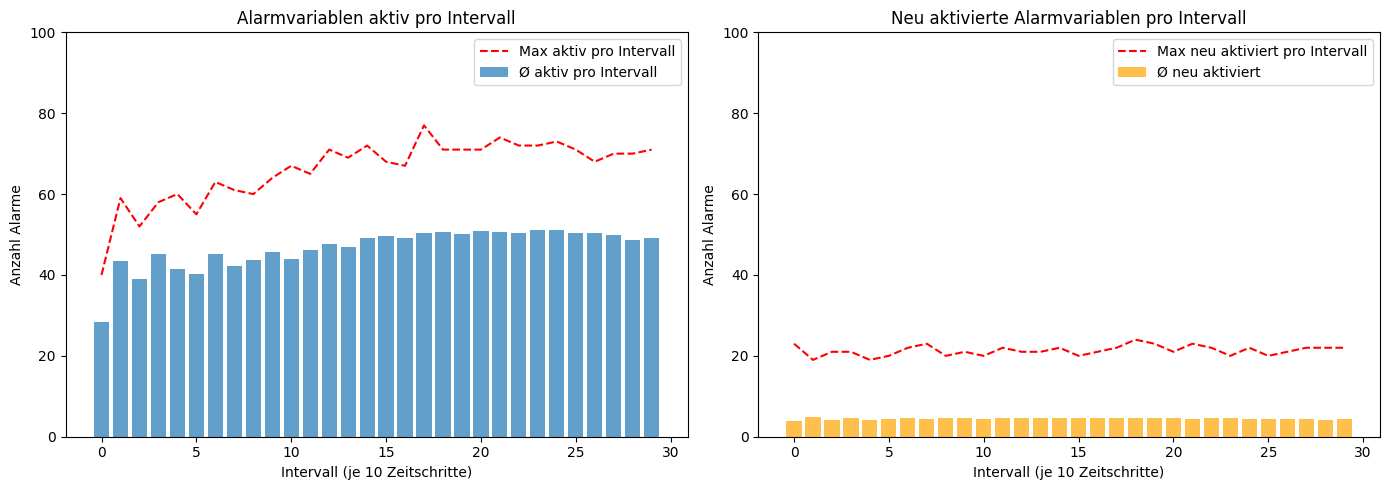

Mittelwert der durchschnittlichen neu aktivierten Alarme pro Intervall: 4.504556666666667


In [9]:
import matplotlib.pyplot as plt
import numpy as np

interval = 10
num_intervals = num_timesteps // interval

# Listen zur Speicherung der Ergebnisse
avg_active_per_interval = []
max_active_per_interval = []

avg_new_active_per_interval = []
max_new_active_per_interval = []

for i in range(num_intervals):
    start = i * interval
    end = (i + 1) * interval
    
    # Ausschnitt der Alarme für aktuelles Intervall
    interval_alarms = X_alarms_deadband[:, :, start:end]
    
    # Überprüfung: war Alarmvariable mindestens einmal im Intervall aktiv? (1 oder 0 pro Variable und Sample)
    active_once = (interval_alarms.sum(axis=2) > 0).astype(int)
    avg_active = active_once.sum(axis=1).mean()          # Mittelwert über alle Samples
    max_active = active_once.sum(axis=1).max()           # Maximum über alle Samples
    
    avg_active_per_interval.append(avg_active)
    max_active_per_interval.append(max_active)
    
    # Neu aktivierte Alarme berechnen (0→1-Übergänge)
    # Für das erste Intervall gibt es kein vorheriges Intervall, daher prepend=0 wie gehabt
    if i == 0:
        alarms_diff = np.diff(interval_alarms, axis=2, prepend=0)
    else:
        # Das letzte Zeitfenster des vorherigen Intervalls als prepend verwenden
        prev_end = i * interval - 1
        # Shape: (num_samples, num_variables*2, 1)
        prepend_slice = X_alarms_deadband[:, :, prev_end][:, :, np.newaxis]
        alarms_diff = np.diff(interval_alarms, axis=2, prepend=prepend_slice)
    new_activations = (alarms_diff == 1).astype(int)
    
    avg_new_active = new_activations.sum(axis=1).mean()  # Mittelwert über alle Samples
    max_new_active = new_activations.sum(axis=1).max()   # Maximum über alle Samples
    
    avg_new_active_per_interval.append(avg_new_active)
    max_new_active_per_interval.append(max_new_active)

# Visualisierung
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.bar(range(num_intervals), avg_active_per_interval, label='Ø aktiv pro Intervall', alpha=0.7)
plt.plot(range(num_intervals), max_active_per_interval, 'r--', label='Max aktiv pro Intervall')
plt.xlabel('Intervall (je 10 Zeitschritte)')
plt.ylabel('Anzahl Alarme')
plt.title('Alarmvariablen aktiv pro Intervall')
plt.ylim(0, 100)
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(range(num_intervals), avg_new_active_per_interval, color='orange', label='Ø neu aktiviert', alpha=0.7)
plt.plot(range(num_intervals), max_new_active_per_interval, 'r--', label='Max neu aktiviert pro Intervall')
plt.xlabel('Intervall (je 10 Zeitschritte)')
plt.ylabel('Anzahl Alarme')
plt.title('Neu aktivierte Alarmvariablen pro Intervall')
plt.ylim(0, 100)
plt.legend()

plt.tight_layout()
plt.show()

print("Mittelwert der durchschnittlichen neu aktivierten Alarme pro Intervall:", np.mean(avg_new_active_per_interval))

## 5. Alarmflutklassifikation

Klassifizieren Sie Alarmfluten mit zwei unterschiedlichen Methoden:

1. **WDI-1NN**: Gewichteter Dissimilaritätsindex mit Nearest Neighbor Klassifikation
2. **ACM-SVM**: Alarm-Coaktivierungsmatrix mit Support Vector Machine Klassifikation

Implementieren Sie dafür ausschließlich die Merkmalsextraktion.  
Die Klassifikationslogik (SVM, 1NN) ist bereits vorgegeben.

In [10]:
from sklearn.model_selection import train_test_split

# Aufteilen der Alarmdaten mit Totband (X_alarms_deadband) und Labels (y) in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(
    X_alarms_deadband, y, test_size=0.2, random_state=42, stratify=y
)

print("Trainingsdaten Shape:", X_train.shape)
print("Testdaten Shape:", X_test.shape)
print("Trainingslabels Shape:", y_train.shape)
print("Testlabels Shape:", y_test.shape)

Trainingsdaten Shape: (800, 146, 300)
Testdaten Shape: (200, 146, 300)
Trainingslabels Shape: (800,)
Testlabels Shape: (200,)


### 5.1 WDI-1NN: Feature-Extraktion (Templates und Gewichte)

Die Methode **Weighted Dissimilarity Index (WDI)** klassifiziert Alarmfluten anhand gewichteter Templates, die charakteristische Alarme für jede Klasse darstellen.

**Ihre Aufgabe:**

- Implementieren Sie die Berechnung der gewichteten Templates (WDI-Feature-Extraktion) basierend auf den bereitgestellten Trainingsdaten.
- Erstellen Sie für jede Alarmklasse ein Template, indem Sie die Häufigkeit der aktivierten Alarmvariablen analysieren.
- Berechnen Sie anschließend die zugehörigen Gewichte der einzelnen Alarmvariablen, um deren Relevanz für die jeweilige Klasse zu bestimmen.

**Schritte im Detail:**

1. Berechnen Sie zunächst die **Templates**:
   - Ein Alarm gehört zum Template, wenn er in mindestens 50% (Threshold = 0.5) der Samples dieser Klasse aktiv war.

2. Berechnen Sie anschließend die **Gewichte** der Alarme:
   - Alarme, die spezifisch für eine Klasse sind, erhalten ein höheres Gewicht.
   - Alarme, die häufig in mehreren Klassen auftreten, erhalten ein geringeres Gewicht.

**Hinweise zur Umsetzung:**

- Nutzen Sie die bereitgestellte Klasse `WDI_1NN` als Vorlage.
- Ergänzen Sie die Methoden:
  - `calc_templates()`: Berechnung der binären Templates aus den Trainingsdaten.
  - `calc_weights()`: Berechnung der Gewichte für die Alarme auf Basis der Templates.

- Verwenden Sie anschließend Ihre implementierten Templates und Gewichte, um die Klassifikation vorzubereiten (die eigentliche Klassifikation ist bereits implementiert).

In [11]:
import numpy as np
import pandas as pd


class WDI_1NN:
    def __init__(self, params={"template_threshold": 0.5}):
        self.classes = None
        self.templates = None
        self.weights_novelty = None
        self.weights_assignment = None
        self.X_active = None
        self.template_threshold = params["template_threshold"]

    @property
    def __name__(self):
        return "WDI_1NN"

    def fit(self, X, y):
        self.calc_templates(X, y)
        self.calc_weights()

    def predict_proba(self, X):
        # Vektoren mit aktiven Alarmen pro Sample erhalten
        X_active = np.array(self.calc_active_alarms(X))
        y_proba = []
        # Über die Samples iterieren
        for i in range(X_active.shape[0]):
            y_assign_i = []
            # Über die Klassen iterieren
            for c in self.classes:
                # Dissimilarität für die Zuordnung berechnen
                if sum(self.weights_assignment[c]) != 0.0:
                    y_assign_i.append(
                        sum(
                            self.weights_assignment[c]
                            * np.abs(X_active[i] - self.templates[c][1])
                        )
                        / sum(self.weights_assignment[c])
                    )
                else:
                    y_assign_i.append(0)
            # Klassendissimilaritäten erhalten
            y_proba.append(y_assign_i)
        return np.array(y_proba)

    def calc_active_alarms(self, X):
        X_active = []
        for i in range(X.shape[0]):
            # In DataFrame umwandeln
            df = pd.DataFrame(X[i].transpose())
            df_max = df.max()
            X_active.append([1 if df_max[j] == 1 else 0 for j in range(X.shape[1])])
        return np.array(X_active)

    def calc_templates(self, X, y):
        # Menge der eindeutigen Klassenlabels in y erhalten
        self.classes = np.unique(y)
        # Vektoren mit aktiven Alarmen pro Sample erhalten
        self.X_active = self.calc_active_alarms(X)
        # Templates pro Klasse erhalten
        templates = {}
        for c in self.classes:
            sample_indices = np.where(y == c)
            class_frequency = sum(self.X_active[sample_indices]) / len(
                sample_indices[0]
            )
            class_template = np.where(class_frequency > self.template_threshold, 1, 0)
            templates[c] = [class_frequency, class_template]
        self.templates = templates

    def calc_weights(self):
        weights_assignment, weights_novelty, alpha_weights, beta_weights = (
            {},
            {},
            {},
            {},
        )
        # Über alle Templates/Klassen iterieren
        for c in self.classes:
            # Alpha-Gewichte berechnen
            alpha_weights[c] = (self.templates[c][0] * self.templates[c][1]) + (
                (1 - self.templates[c][0]) * np.where(self.templates[c][1] == 1, 0, 1)
            )
        for c in self.classes:
            # Beta-Gewichte berechnen
            beta_weights[c] = (sum(alpha_weights.values()) - alpha_weights[c]) / (
                self.classes.shape[0] - 1
            )
            # Gesamte Gewichte berechnen
            weights_novelty[c] = 2 * alpha_weights[c] - 1
            weights_assignment[c] = (2 * alpha_weights[c] - 1) * (1 - beta_weights[c])
            
        self.weights_assignment = weights_assignment
        self.weights_novelty = weights_novelty


### 5.2 ACM-SVM: Feature-Extraktion (Alarm-Koaktivierungsmatrix)

Die Methode **Alarm Coactivation Matrix (ACM)** klassifiziert Alarmfluten basierend auf den dynamischen Mustern gleichzeitiger Alarmaktivierungen (Koaktivierungen).

**Ihre Aufgabe:**

Implementieren Sie die Berechnung der Alarm-Koaktivierungsmatrix (ACM):

- Die ACM beschreibt, wie häufig zwei Alarmvariablen gleichzeitig aktiviert sind. Dazu verwenden Sie die **Jaccard-Ähnlichkeit** zwischen jedem Paar von Alarmvariablen.
- Die berechneten Koaktivierungswerte bilden anschließend die Grundlage für eine Klassifikation mit einer Support Vector Machine (SVM).

**Schritte im Detail:**

1. Für jedes Sample berechnen Sie die Jaccard-Ähnlichkeit für jedes Paar von Alarmvariablen über alle Zeitschritte hinweg:
   - Jaccard-Ähnlichkeit = Anzahl gemeinsamer Aktivierungen (Schnittmenge) geteilt durch Anzahl aller Aktivierungen mindestens einer der beiden Alarme (Vereinigung).

2. Die resultierende ACM ist ein Merkmalsvektor pro Sample, der die Jaccard-Werte für alle Variablenpaare enthält.

3. Verwenden Sie anschließend Ihre implementierte ACM zur Vorbereitung der Klassifikation (die eigentliche SVM-Klassifikation ist bereits implementiert).

**Hinweise zur Umsetzung:**

- Nutzen Sie die bereitgestellte Klasse `ACM_SVM` als Vorlage.
- Ergänzen Sie die Methode:
  - `calc_coactivation()`: Berechnung der ACM aus den Alarmdaten anhand der Jaccard-Ähnlichkeit.
- Stellen Sie sicher, dass Ihre Berechnung die richtige Form `(Anzahl der Samples, Anzahl Variablenpaare)` hat.

In [12]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


class ACM_SVM:
    def __init__(self, params={}):
        self.clf = None

    @property
    def __name__(self):
        return "ACM_SVM"

    def fit(self, X, y):
        # Alarm-Koaktivierungen berechnenerechnenerechnen
        X_acm = self.calc_coactivation(X)
        # SVM mit One-vs-One-Schema trainierenereneren
        self.clf = make_pipeline(StandardScaler(), SVC(probability=True))
        self.clf.fit(X_acm, y)

    def predict_proba(self, X):
        # Alarm-Koaktivierungen berechnenerechnenerechnen
        X_acm = self.calc_coactivation(X)
        # Posteriori-Klassenwahrscheinlichkeiten erhaltenri-Klassenwahrscheinlichkeiten erhalten
        y_scores = self.clf.predict_proba(X_acm)
        return np.array(y_scores)

    def calc_coactivation(self, X):
        n_samples, n_variables, _ = X.shape
        # Initialize the result array with zeros
        result = np.zeros((n_samples, n_variables * (n_variables - 1) // 2))

        # Iterate over each sample
        for i in range(n_samples):
            # Initialize a list to store the Jaccard scores for this sample
            jaccard_scores = []

            # Iterate over each pair of variables
            for v1 in range(n_variables):
                for v2 in range(v1 + 1, n_variables):
                    # Compute the intersection and union of activations for the pair
                    intersection = np.sum((X[i, v1, :] == 1) & (X[i, v2, :] == 1))
                    union = np.sum((X[i, v1, :] == 1) | (X[i, v2, :] == 1))

                    # Calculate the Jaccard score
                    if union == 0:
                        jaccard_score = 0
                    else:
                        jaccard_score = intersection / union

                    # Add the Jaccard score to the list
                    jaccard_scores.append(jaccard_score)

            # Store the Jaccard scores in the result array
            result[i, :] = jaccard_scores

        return result


### 5.3 Training der Klassifikationsmodelle

Dieser Schritt ist bereits implementiert. Hier werden die extrahierten Merkmale für das Training verwendet.

In [13]:
# WDI-1NN Modell trainieren
wdi_model = WDI_1NN(params={"template_threshold": 0.5})
wdi_model.fit(X_train, y_train)

In [14]:
# ACM-SVM Modell trainieren
acm_model = ACM_SVM()
acm_model.fit(X_train, y_train)

## 6. Evaluierung der Klassifikation

Evaluieren Sie nun Ihre beiden Klassifikationsmodelle auf dem Testset:

- Berechnung und Ausgabe der Genauigkeit (Accuracy)
- Erzeugung einer Confusion Matrix zur Ergebnisbewertung

WDI-1NN Accuracy: 0.925


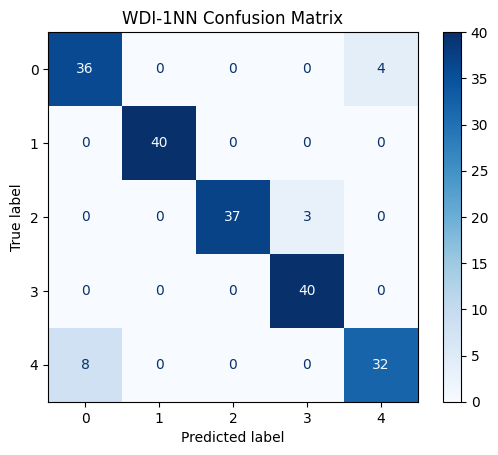

ACM-SVM Accuracy: 0.985


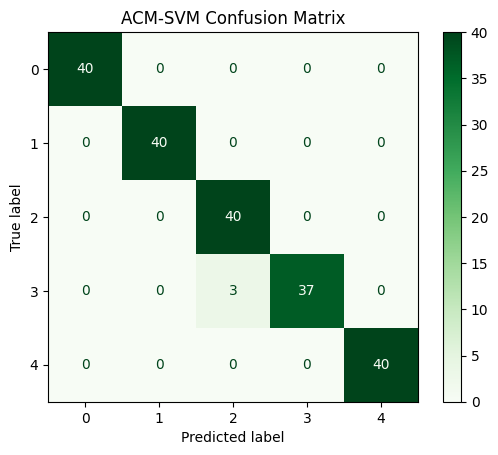

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

import matplotlib.pyplot as plt

# WDI-1NN Vorhersagen
wdi_probs = wdi_model.predict_proba(X_test)
wdi_preds = np.argmin(wdi_probs, axis=1)
wdi_acc = accuracy_score(y_test, wdi_preds)
wdi_cm = confusion_matrix(y_test, wdi_preds)

print(f"WDI-1NN Accuracy: {wdi_acc:.3f}")
disp1 = ConfusionMatrixDisplay(wdi_cm)
disp1.plot(cmap="Blues")
plt.title("WDI-1NN Confusion Matrix")
plt.show()

# ACM-SVM Vorhersagen
acm_probs = acm_model.predict_proba(X_test)
acm_preds = np.argmax(acm_probs, axis=1)
acm_acc = accuracy_score(y_test, acm_preds)
acm_cm = confusion_matrix(y_test, acm_preds)

print(f"ACM-SVM Accuracy: {acm_acc:.3f}")
disp2 = ConfusionMatrixDisplay(acm_cm)
disp2.plot(cmap="Greens")
plt.title("ACM-SVM Confusion Matrix")
plt.show()